In [1]:
import os, multiprocessing, sys
import copy
import math
from array import array
from ROOT import ROOT, gROOT, gStyle, gRandom, TSystemDirectory
from ROOT import TFile, TChain, TTree, TCut, TH1, TH1F, TH2F, THStack, TGraph, TGraphAsymmErrors
from ROOT import TStyle, TCanvas, TPad
from ROOT import TLegend, TLatex, TText, TLine, TBox
import time
#%jsroot on
cwd=os.getcwd()
sys.path.append(cwd+"/Utils/")

from drawLambda import *
from variables import *
from selections_SSLep import *
from samplesVH import *

gROOT.SetBatch(True)
gStyle.SetOptStat(0)
gROOT.Macro('functions.C')

Welcome to JupyROOT 6.12/06


0L

In [2]:
NTUPLEDIR   = "/Users/shoh/Projects/CMS/PhD/Analysis/SSL/datav8-skim/"
LUMI        = 35800. # pb-1                                                                                                                
data = ["data_obs"]
#back = [ "DYJetsToLL" , "WJetsToLNu" , "TTbar-DiLep" , "ST" , "TTbar-SL" , "WZ" , "WW" , "ttV" ]                                                 
back        = [ "ttV" , "VV" , "TTbar-SL", "ST", "TTbar-DiLep", "WJetsToLNu" , "DYJetsToLL" ]
sign=[]
BLIND=False
POISSON= False
SIGNAL      = 1.
RATIO       = 4
jobs        = []

In [3]:
var="Zmass"
cutchoice="OSmumu"
TRIGGER=muonTrigger
cut=TRIGGER+" && "+selection[cutchoice]
print cut
pd = getPrimaryDataset(cut)

(HLT_IsoMu22 || HLT_IsoMu22_eta2p1 || HLT_IsoTkMu22_eta2p1 || HLT_IsoMu24 || HLT_IsoTkMu24 || HLT_Mu45_eta2p1 || HLT_Mu50) && (( (HLT_IsoMu22 || HLT_IsoMu22_eta2p1 || HLT_IsoTkMu22_eta2p1 || HLT_IsoMu24 || HLT_IsoTkMu24 || HLT_Mu45_eta2p1 || HLT_Mu50) ) && ( (( 1==1 ) && ( (Muon_charge[0]!=Muon_charge[1]) && Muon_pt[0]>17 && Muon_pt[1]>8 && Muon_pfRelIso03_all[0]<0.15 && Muon_pfRelIso03_all[1]<0.15 )) ))


In [4]:
def plot(vv, ss, PD):
    
    if vv=="Zmass":
        vvv="invariantMass(Muon_pt[0], Muon_eta[0], Muon_phi[0], Muon_mass[0], Muon_pt[1], Muon_eta[1], Muon_phi[1], Muon_mass[1])"
    elif vv=="Zpt":
        vvv="invariantMassPt(Muon_pt[0], Muon_eta[0], Muon_phi[0], Muon_mass[0], Muon_pt[1], Muon_eta[1], Muon_phi[1], Muon_mass[1])"
    else:
        vvv=vv
    
    histcarrier={}
    histlet={}
    if not BLIND:
        processes=data+back
    elif BLIND:
        processes=back

    for TAG in (processes):
        #print "TAG: ", TAG
        ENUMLIST=[]
        if 'data' in TAG:
            for datalet in (samples['%s' %TAG]['files']):
                if datalet in pd:
                    ENUMLIST.append(datalet)
        elif not 'data' in TAG:
            ENUMLIST=samples['%s' %TAG]['files']
     
        for num, bkgs in enumerate(ENUMLIST):
         
            #print num, bkgs
            f = TFile.Open(NTUPLEDIR+bkgs+".root","READ")
            tree = f.Get("Events")
            gROOT.cd()
            #Define histograms
            if not 'data' in TAG:
                nevents = sample[bkgs]['nevents']
                xs = sample[bkgs]['xsec']
                LumiMC = nevents/xs
                Weight = float(LUMI) / float(LumiMC)
        
            if num==0:
                if variable[vv]['nbins']>0: histlet[TAG] = TH1F(bkgs, ";"+variable[vv]['title'], variable[vv]['nbins'], variable[var]['min'\
], variable[vv]['max'])
                else: histlet[TAG]=TH1F(bkgs,";"+variable[vv]['title'], len(variable[vv]['bins'])-1, array('f', variable[var]['bins']))
                histlet[TAG].Sumw2()
                if 'data' in TAG:
                    print "DATA, NO HLT : ", bkgs
                    subcut= ss.replace(TRIGGER,"(1==1)")
                    tree.Draw("%s >> %s" %(vvv,bkgs),"%s" %subcut)
                elif not 'data' in TAG:
                    print "MC, With HLT"
                    tree.Draw("%s >> %s" %(vvv,bkgs),"%s*(%s)" %(Weight,ss))
                #print histlet[TAG].Print()
            elif num>0:
                if variable[vv]['nbins']>0: histcarrier[bkgs] = TH1F(bkgs, ";"+variable[vv]['title'], variable[vv]['nbins'], variable[vv][\
'min'], variable[vv]['max'])
                else: histcarrier[bkgs]=TH1F(bkgs,";"+variable[vv]['title'], len(variable[vv]['bins'])-1, array('f', variable[vv]['bins']))
                histcarrier[bkgs].Sumw2()
                if 'data' in TAG:
                    #print "DATA, NO HLT : ", bkgs
                    subcut= ss.replace(TRIGGER,"(1==1)")
                    tree.Draw("%s >> %s" %(vvv,bkgs),"%s" %subcut)
                elif not 'data' in TAG:
                    #print "MC, With HLT"
                    tree.Draw("%s >> %s" %(vvv,bkgs),"%s*(%s)" %(Weight,ss))
                hnew = histcarrier[bkgs].Clone(bkgs)
                histlet[TAG].Add(hnew)
        histlet[TAG].SetFillColor(samples[TAG]['fillcolor'])
        histlet[TAG].SetFillStyle(samples[TAG]['fillstyle'])
        histlet[TAG].SetLineColor(samples[TAG]['linecolor'])
        histlet[TAG].SetLineStyle(samples[TAG]['linestyle'])
    #return histlet
    
    if len(back)>0:
        histlet['BkgSum'] = histlet['data_obs'].Clone("BkgSum") if 'data_obs' in histlet else histlet[back[0]].Clone("BkgSum")
        histlet['BkgSum'].Reset("MICES")
        histlet['BkgSum'].SetFillStyle(3003)
        histlet['BkgSum'].SetFillColor(1)
        for i, s in enumerate(back): histlet['BkgSum'].Add(histlet[s])
    #return histlet
    
    if len(back)==0 and len(data)==0:
        for i, s in enumerate(sign):
            histlet[s].Scale(1./histlet[s].Integral())
            histlet[s].SetFillStyle(0)
    if len(data+back)>0:
        out = draw(histlet, data if not BLIND else [], back, sign, SIGNAL, RATIO, POISSON, variable[var]['log'])
    else:
        out = drawSignal(histlet, sign, variable[var]['log'])
    out[0].cd(1)
    if len(data+back)>0:
        drawCMS(LUMI, "Preliminary")
    else:
        drawCMS(LUMI, "Simulation")
    out[0].Update()
    
    #for process in histlet:
     #   histlet[process].Delete()

    return out

DATA, NO HLT :  SingleMuonRun2016B-03Feb2017_ver1-v1
MC, With HLT
MC, With HLT
MC, With HLT
MC, With HLT
MC, With HLT
MC, With HLT
MC, With HLT
  Ratio:	1.149 +- 0.002


Info in <TCanvas::MakeDefCanvas>:  created default TCanvas with name c1
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Info in <TH1F::Chi2TestX>: There is a bin in h2 with less than 10 effective events.



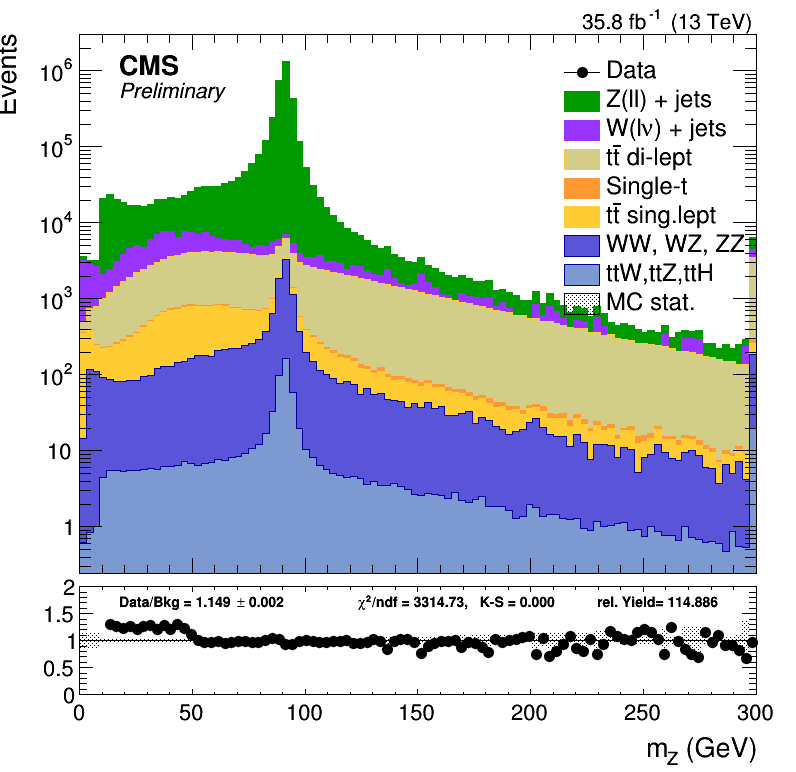

In [5]:
canvas=plot(var, cut, pd)
canvas[0].Draw()